In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import random

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc
from matplotlib import pyplot as plt

tqdm.pandas()


SEED = 254290

np.random.seed(SEED)
random.seed(SEED)

In [16]:
SPEECH_DATA_DIR = Path("../data/speech")
SPEECH_PLOTS_DIR = Path("../plots/speech")
AUDIO_DIR = SPEECH_DATA_DIR / "concat_audio"

narysuj krzywe FAR,
FRR,
wyznacz EER
narysuj ROC


zmierz PSNR,
SSIM oraz BRISQUE.

In [3]:
registration_df = pd.read_csv(SPEECH_DATA_DIR / "concat_audio_registration_df.csv")
registration_df

,speaker_id,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath
0,id00694,IgUtEqwqXgg,wav,2,2,16000,588800,36.80,../data/speech/concat_audio/id00694/IgUtEqwqXg...
1,id00799,ELtVwFSaak0,wav,2,2,16000,119680,7.48,../data/speech/concat_audio/id00799/ELtVwFSaak...
2,id00868,9SHE8pQGkf4,wav,2,2,16000,243200,15.20,../data/speech/concat_audio/id00868/9SHE8pQGkf...
3,id01616,18lc1aMx5ZM,wav,2,2,16000,583680,36.48,../data/speech/concat_audio/id01616/18lc1aMx5Z...
4,id02799,aqfXg_jXqjw,wav,2,2,16000,16000,1.00,../data/speech/concat_audio/id02799/aqfXg_jXqj...
...,...,...,...,...,...,...,...,...,...
94,id58163,jqZ3ZWcYvnU,wav,2,2,16000,344320,21.52,../data/speech/concat_audio/id58163/jqZ3ZWcYvn...
95,id58257,aCN3x_uGAEs,wav,2,2,16000,17920,1.12,../data/speech/concat_audio/id58257/aCN3x_uGAE...
96,id60231,oRAyifLDyd4,wav,2,2,16000,597120,37.32,../data/speech/concat_audio/id60231/oRAyifLDyd...
97,id60691,4emJHSSJhnU,wav,2,2,16000,169600,10.60,../data/speech/concat_audio/id60691/4emJHSSJhn...


In [4]:
from speech_users_db import SpeechUsersDB

db = SpeechUsersDB()

for index, row in tqdm(list(registration_df.iterrows())):
    db.add_record(row["speaker_id"], row["VideoFpath"], cache=True)

  0%|          | 0/99 [00:00<?, ?it/s]

Pomyślnie dodano nową osobe id_='id00694' :) 
Pomyślnie dodano nową osobe id_='id00799' :) 
Pomyślnie dodano nową osobe id_='id00868' :) 
Pomyślnie dodano nową osobe id_='id01616' :) 
Pomyślnie dodano nową osobe id_='id02799' :) 
Pomyślnie dodano nową osobe id_='id03884' :) 
Pomyślnie dodano nową osobe id_='id04903' :) 
Pomyślnie dodano nową osobe id_='id05137' :) 
Pomyślnie dodano nową osobe id_='id05768' :) 
Pomyślnie dodano nową osobe id_='id05829' :) 
Pomyślnie dodano nową osobe id_='id06007' :) 
Pomyślnie dodano nową osobe id_='id06304' :) 
Pomyślnie dodano nową osobe id_='id07057' :) 
Pomyślnie dodano nową osobe id_='id08519' :) 
Pomyślnie dodano nową osobe id_='id08661' :) 
Pomyślnie dodano nową osobe id_='id08776' :) 
Pomyślnie dodano nową osobe id_='id09427' :) 
Pomyślnie dodano nową osobe id_='id09527' :) 
Pomyślnie dodano nową osobe id_='id09582' :) 
Pomyślnie dodano nową osobe id_='id10357' :) 
Pomyślnie dodano nową osobe id_='id10916' :) 
Pomyślnie dodano nową osobe id_='i

In [5]:
df1 = pd.read_csv(SPEECH_DATA_DIR / "df1.csv")
df1

,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath,truth,speaker_id
0,HoPP5mYWyxY,wav,2,2,16000,654720,40.92,../data/speech/concat_audio/id41102/HoPP5mYWyx...,False,id38620
1,4DV8YuFjrNk,wav,2,2,16000,140800,8.80,../data/speech/concat_audio/id41102/4DV8YuFjrN...,False,id25408
2,k5CC_ZzGR-Q,wav,2,2,16000,229120,14.32,../data/speech/concat_audio/id41102/k5CC_ZzGR-...,False,id35186
3,P63okDJgrJE,wav,2,2,16000,378240,23.64,../data/speech/concat_audio/id41102/P63okDJgrJ...,False,id47667
4,BqsRCddbzFo,wav,2,2,16000,771200,48.20,../data/speech/concat_audio/id41102/BqsRCddbzF...,False,id08519
...,...,...,...,...,...,...,...,...,...,...
1017,QJ_Bgup5PkE,wav,2,2,16000,36480,2.28,../data/speech/concat_audio/id34371/QJ_Bgup5Pk...,True,id34371
1018,O1X-s1Lq5ag,wav,2,2,16000,40960,2.56,../data/speech/concat_audio/id34371/O1X-s1Lq5a...,True,id34371
1019,AsnNeQxfmIE,wav,2,2,16000,19840,1.24,../data/speech/concat_audio/id34371/AsnNeQxfmI...,True,id34371
1020,-b7kZx51oi0,wav,2,2,16000,40320,2.52,../data/speech/concat_audio/id34371/-b7kZx51oi...,True,id34371


In [6]:
# df2 = pd.read_csv("./data/df2.csv")
# df2

In [7]:
# df3 = pd.read_csv("./data/df3.csv")
# df3

In [8]:
# df4 = pd.read_csv("./data/df4.csv")
# df4

In [17]:
# Define a function to calculate FAR
def calculate_far(df, threshold):
    # Count false acceptances
    false_acceptances = df[(df['authorized'] == True)&(df['truth'] == False)&(df['threshold'] == threshold)].shape[0]
    # Get the total number of identification attempts
    total_attempts = df[(df['truth'] == False)&(df['threshold'] == threshold)].shape[0]
    # Calculate FAR
    return false_acceptances / total_attempts


# Function to calculate FRR
def calculate_frr(dataframe, threshold):
    # Count false rejections
    false_rejections = dataframe[(dataframe['authorized'] == False) &(dataframe['truth'] == True)&(dataframe['threshold'] == threshold)].shape[0]
    # Get the total number of identification attempts by authorized users
    total_authorized_attempts = dataframe[(dataframe['truth'] == True)&(dataframe['threshold'] == threshold)].shape[0]
    # Calculate FRR
    if total_authorized_attempts == 0:
        return 0
        
    return false_rejections / total_authorized_attempts


# Function to calculate EER
def calculate_eer(far_values, frr_values, threshold_values):
    # Initialize the difference to a large number
    min_diff = float('inf')
    eer = 1
    eer_threshold = 0
    # Loop through all FAR and FRR values to find the EER
    for far, frr, threshold in zip(far_values, frr_values, threshold_values):
        # Calculate the absolute difference between FAR and FRR
        diff = abs(far - frr)
        # If this is the smallest difference we've found, update the EER values
        if diff < min_diff:
            min_diff = diff
            eer = (far + frr) / 2  # Take the average to get EER when FAR is close to FRR
            eer_threshold = threshold
    return eer, eer_threshold


def run_exp(db, df, threshold_values, dataset_name="Dataset ##"):
    auth_history = []
    for threshold in tqdm(threshold_values, desc="Exp Thresholds"):
        for _, row in df.iterrows():
            audio_fpath = row["VideoFpath"]
            distance, authorized = db.verify_user(audio_fpath, row["speaker_id"], threshold=threshold, cache=True)
            auth_history.append({
                # "image": row["image"],
                "identity": row["speaker_id"],
                "authorized": authorized,
                "truth": row["truth"],
                "distance": distance,
                "threshold": threshold,
            })

    auth_history_df = pd.DataFrame.from_records(auth_history)

    threshold_metrics = []
    for threshold in threshold_values:
        threshold_metrics.append({
            "threshold": threshold,
            "far": calculate_far(auth_history_df, threshold),
            "frr": calculate_frr(auth_history_df, threshold),
        })

    threshold_metrics_df = pd.DataFrame.from_records(threshold_metrics)
    eer, eer_threshold = calculate_eer(threshold_metrics_df["far"].values, threshold_metrics_df["frr"].values, threshold_values)

    threshold_auth_history_df = auth_history_df[auth_history_df["threshold"] == eer_threshold]

    cm = confusion_matrix(df["truth"].values, threshold_auth_history_df["authorized"].tolist())
    # tn, fp, fn, tp = cm.ravel()

    report = classification_report(df["truth"].tolist(), threshold_auth_history_df["authorized"].tolist())
    print(report)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    sns.lineplot(
        data=threshold_metrics_df,
        x="threshold",
        y="far",
        marker=".",
        label="FAR (False Acceptance Rate)",
        zorder=1,
        ax=axes[0],
    )
    sns.lineplot(
        data=threshold_metrics_df,
        x="threshold",
        y="frr",
        marker=".",
        label="FRR (False Rejection Rate)",
        zorder=1,
        ax=axes[0],
    )
    sns.scatterplot(
        x=[eer_threshold],
        y=[eer],
        color="red",
        label=f"EER = {eer:.2f} (threshold={eer_threshold:.2f})",
        zorder=2,
        ax=axes[0]
    )
    axes[0].set_xlabel("Threshold")
    axes[0].set_ylabel("Rate")
    axes[0].grid(alpha=0.2)
    # plt.show()

    sns.heatmap(cm, annot=True, ax=axes[1], fmt='d', cmap="Blues")
    axes[1].set_title(f"Confusion Matrix ({eer_threshold=:.2f})")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    # plt.show()

    fpr, tpr, thresholds = roc_curve(df["truth"].values, threshold_auth_history_df["distance"].values)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[2])
    axes[2].set_title(f"ROC Curve")
    # plt.show()

    fig.suptitle(f"{dataset_name}    Threshold: {eer_threshold:.2f} (EER)\n")
    fig.savefig(SPEECH_PLOTS_DIR / f"exp__{dataset_name}.png")
    fig.show()


In [18]:
THRESHOLD_VALUES = np.linspace(0.1, 0.8, 10)

Exp Thresholds:   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.96      0.95      0.96       511
        True       0.96      0.96      0.96       511

    accuracy                           0.96      1022
   macro avg       0.96      0.96      0.96      1022
weighted avg       0.96      0.96      0.96      1022



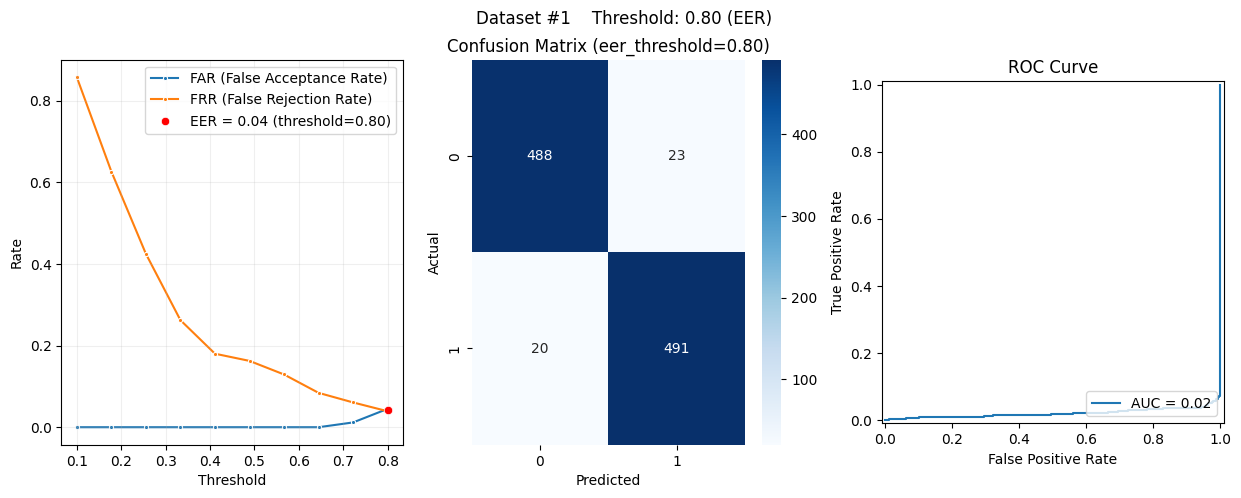

In [19]:
run_exp(db, df1, THRESHOLD_VALUES, dataset_name=f"Dataset #1")